# Машинное обучение, DS-поток, осень 2024
## Задание ML.12


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание**  
Задача 1 &mdash; **100 баллов**  
Задача 2 &mdash; **80 баллов**  

Всего &mdash; **180 баллов**  

In [132]:
from functools import lru_cache
import os
import numpy as np
from PIL import Image
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision 
!pip install -q monai
import monai
from sklearn.model_selection import train_test_split
from pathlib import Path
!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp
import random
random.seed(10)
import warnings
warnings.filterwarnings("ignore")

In [133]:
# Bot check

# HW_ID: ds_ml12
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

### Данные

Мы предлагаем вам поработать с подмножеством датасета [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge) с Kaggle. Carvana &mdash; это онлайн магазин подержаннных aвтомобилей. Компания организовала соревнование для того, чтобы получить модель, с помощью которой получилось бы автоматически сегментировать авто на фотографии. Затем, используя маску для автомобиля, его можно было использовать для получения более интересных фотографий с автомобилем.


Мы не будем использовать использовать датасет целиком, так как он очень большой, а для наших целей хватит небольшой его части.

Скачайте архив с даными [здесь](https://drive.google.com/file/d/1UbXOTP6GIp1pp-LwwpfX1p8m6iaWXzM1/view?usp=drive_link). Как работать со внешними данными на Google Colab или Kaggle описано в предыдущем домашнем задании.

In [134]:
# zip_path = ...
data_path = Path('../input/carvana')
# zip_path_bash = str(zip_path).replace(' ', '\ ')
# !unzip $zip_path_bash -d $data_path

# на kaggle теперь распаковывается автоматически

Данные уже разделены на трейн и тест. В папках `train` и `train_masks` лежат изображения автомобилей и их маски соответственно. Аналогично для папок `test` и `test_masks`.

In [135]:
!ls $data_path

test  test_masks  train  train_masks


Изображения и маски имеют одинаковое начало названия. Название файла маски отличается тем, что есть окончание `_mask`, а также сам файл имеет другой формат &mdash; gif вместо jpg. Так можно получить изображение и его маску из трейна.

In [136]:
img_name = "0cdf5b5d0ce1_01.jpg"
splitted = img_name.split('.')
mask_name = splitted[0] + "_mask" + ".gif"

img_path = os.path.join(data_path, "train", img_name)
mask_path = os.path.join(data_path, "train_masks", mask_name)

Визуализируем изображение и маску.

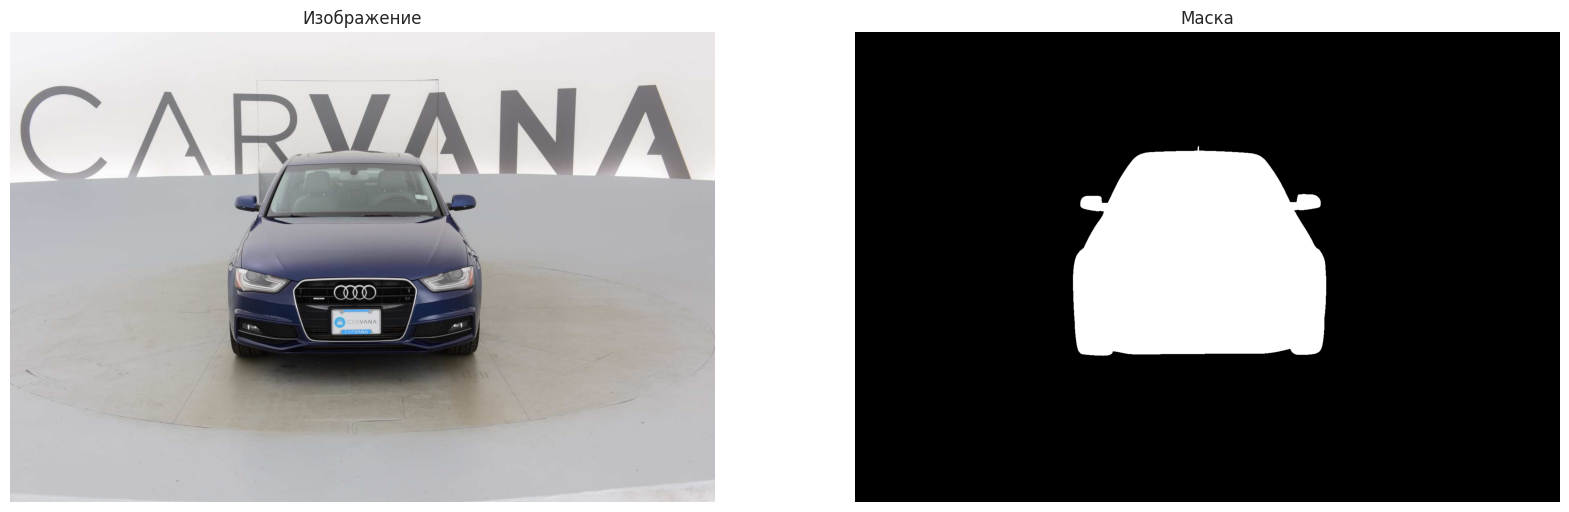

In [137]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(Image.open(mask_path))  # маски бинарные
plt.axis("off");

Исходные изображения довольно большие. Предлагаем вам работать с изображениями меньшего размера, а именно (160, 240) для уменьшения вычислительных затрат. Не забудьте сделать соответствующее преобразование.

In [138]:
np.array(Image.open(img_path)).shape

(1280, 1918, 3)

*Отщепим от трейна валидацию*

In [139]:
train_images, test_images = os.listdir(data_path / 'train'), os.listdir(data_path / 'test')
random.shuffle(train_images)
val_images = train_images[:len(train_images)//5]  # 20% -> в валидацию
train_images = list(set(train_images) - set(val_images))
assert len(set(train_images).intersection(set(val_images))) == 0 # убедились, что ликов нет
img_list = {'train':train_images, 'val':val_images, 'test':test_images}

*Сразу создадим датасет*

In [140]:
class CarvanaDataset(Dataset):
    def __init__(self, mode='train', transform=None):
        map = {'train':'train', 'val':'train', 'test':'test'}[mode]
        self.img_dir, self.mask_dir, self.img_names = data_path / map, data_path / f"{map}_masks", img_list[mode]
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def _load(self, img_name):
        mask_name = img_name.split('.')[0]+"_mask.gif"
        image = np.array(Image.open(self.img_dir / img_name))
        mask = np.array(Image.open(self.mask_dir / mask_name))
        return image, mask

    def __getitem__(self, idx):
        image, mask = self._load(self.img_names[idx])
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
        return image, mask

In [141]:
size = (160, 256)  # вероятно, в условии (160, 240) - опечатка: Expected image height and width divisible by 32
train_transform = A.Compose([
    A.Resize(*size),  
    # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),  # аугментации явно не упоминались, начнем без них
    # A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
    # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    # A.GaussNoise(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
val_test_transform = A.Compose([
    A.Resize(*size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

batch_size, num_workers = 32, 2
train_dataset = CarvanaDataset('train', transform=train_transform)
val_dataset = CarvanaDataset('val', transform=val_test_transform)
test_dataset = CarvanaDataset('test', transform=val_test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

### Задача 1. Простая сегментация
Вы построите свою собственную модель сегментации и проведете анализ ее работы.

In [142]:
max_epochs = 12

#### 1. Обучение сегментации

Постройте модель типа U-Net. Вы можете использовать непосредственно первоначальную версию U-Net (рассматривали на лекции), либо ее модификацию, либо любую другую модель типа кодировщик-декодировщик с skip-connection конструкцией.

In [143]:
class SegmentationModel(pl.LightningModule):
    def __init__(self):
        '''Инициализация'''
        super().__init__()
        self.lr = 3e-4
        self.criterion = nn.BCEWithLogitsLoss()
        self.save_hyperparameters()
        self.model = smp.UnetPlusPlus(in_channels=3, classes=1, encoder_name='timm-efficientnet-b4', encoder_weights=None)  # unet++
        self.predictions = []
        self.logs = {'Лосс':{'train':[],'val':[]}, 'IoU':{'train':[],'val':[]}}
        self.training_step_outputs_loss, self.training_step_outputs_iou = [],[]
        self.validation_step_outputs_loss, self.validation_step_outputs_iou = [],[]
        self.change_bg_color = False

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

    def __step(self, batch):
        '''Лосс с 1 шага обучения по батчу'''
        images, target = batch
        output = self.forward(images)[:,0,...]
        target = target.float()
        loss = self.criterion(output, target)
        pred = (torch.sigmoid(output) >= 0.5)
        inter, union = torch.logical_and(target, pred).sum(), torch.logical_or(target, pred).sum() 
        iou = inter / union if union != 0 else torch.tensor(0.0)
        return loss, iou

    def training_step(self, batch, batch_idx):
        '''Шаг трейна'''
        loss, iou = self.__step(batch)
        self.training_step_outputs_loss.append(loss)
        self.training_step_outputs_iou.append(iou)
        return loss

    def on_train_epoch_end(self):
        '''Логи в конце трейна'''
        self.logs['Лосс']['train'].append(torch.stack(self.training_step_outputs_loss).mean().item())
        self.logs['IoU']['train'].append(torch.stack(self.training_step_outputs_iou).mean().item())
        self.training_step_outputs_loss.clear()
        self.training_step_outputs_iou.clear()

    def validation_step(self, batch, batch_idx):
        '''Шаг валидации'''
        loss, iou = self.__step(batch)
        self.validation_step_outputs_loss.append(loss)
        self.validation_step_outputs_iou.append(iou)
        return loss

    def on_validation_epoch_end(self):
        '''Логи в конце валидации'''
        self.logs['Лосс']['val'].append(torch.stack(self.validation_step_outputs_loss).mean().item())
        self.logs['IoU']['val'].append(torch.stack(self.validation_step_outputs_iou).mean().item())
        self.validation_step_outputs_loss.clear()
        self.validation_step_outputs_iou.clear()

    def test_step(self, batch, batch_idx):
        '''Тестоый прогон'''
        images, targets = batch
        if self.change_bg_color:  # меняем цвет фона
            images[:,0,...] *= targets  # зануляем один цветовой канал у фона всех кадров
            
        targets = targets.float()
        outputs = self.forward(images)[:,0,...]
        pred_masks = (torch.sigmoid(outputs) >= 0.5)
        for img, pred, target in zip(images, pred_masks, targets):
            inter, union = torch.logical_and(target, pred).sum(), torch.logical_or(target, pred).sum() 
            iou = inter / union if union != 0 else torch.tensor(0.0)
            if self.change_bg_color:  # меняем цвет фона, сохраняем еще и измененный кадр
                self.predictions.append((img.cpu().numpy(), pred.cpu().numpy(), iou))
            else:  # обычный прогон
                self.predictions.append((pred.cpu().numpy(), iou))

    def visualize(self):
        '''Визуализация кривых лосса и iou'''
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        for ax, param in zip(axs, ['Лосс','IoU']):
            ax.plot(self.logs[param]['train'], label='Трейн')
            ax.plot(self.logs[param]['val'][1:], label='Валидация')
            ax.set_title(f'{param} в динамике')
            ax.set_xlabel('Эпоха')
            ax.set_ylabel(param)
            ax.legend()
        plt.tight_layout()
        plt.show()

Обучите модель на тренировочной части данных. В качестве метрики качества используйте IoU. Визуализируйте изменение ошибки (loss) и метрики (IoU) на тренировочной и тестовой части данных.

In [ ]:
model = SegmentationModel()
trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[pl.callbacks.ModelCheckpoint()])
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

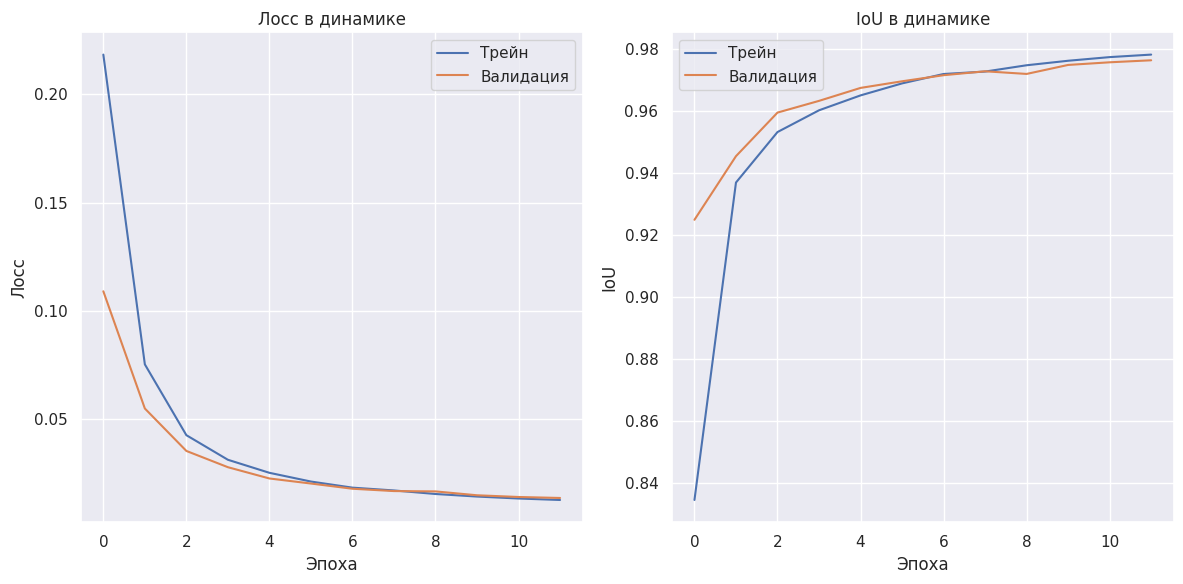

In [145]:
model.visualize()

*Лосс падает, IoU растет. Значит, всё работает и обучается*

Как быстро обучается модель? Как вы думаете, с чем это связано?

***Ответ:** модель обучается довольно медленно. Причины: маленький батч (батчи побольше не помещались на гпу), большая модель (подбираются много параметров), сложности с загрузкой тяжелых картинок и масок*

#### 2. Анализ модели
Выберите 10 изображений из тестовой части данных и посчитайте качество модели на них. Теперь поменяйте фон для изображений. Можно, например, поменять его цвет. Проверьте качество модели на новых изображениях.

Testing: |          | 0/? [00:00<?, ?it/s]

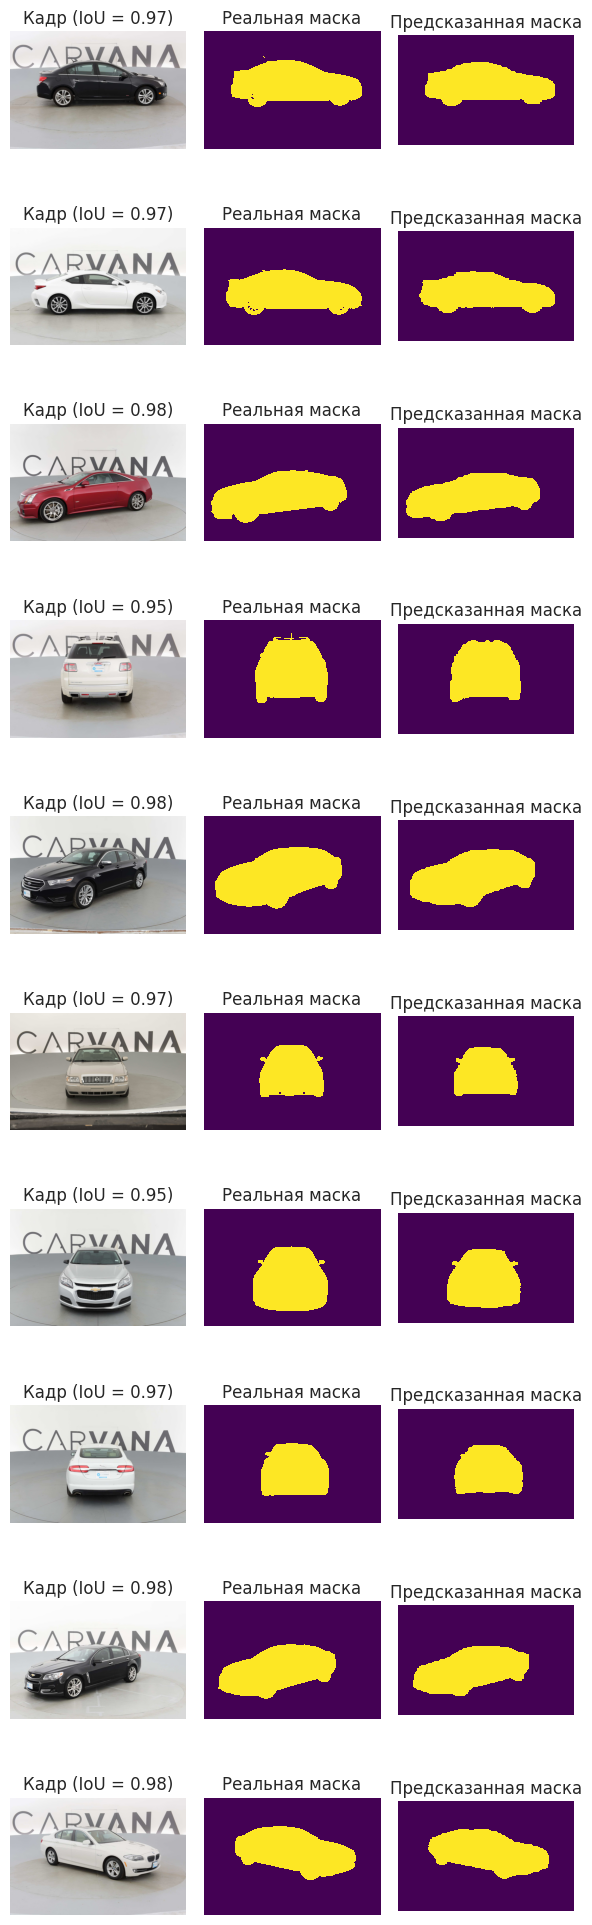

In [146]:
trainer.test(model, dataloaders=test_loader)
pred_masks, ious = [mask for mask, _ in model.predictions], [iou for _, iou in model.predictions]

images_filenames = test_images[:10]
cols, rows = 3, len(images_filenames)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 20))
plt.title('Работа сети')
for i, img_name in enumerate(images_filenames):
    image, mask = test_dataset._load(img_name)  
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, interpolation="nearest", cmap='viridis')
    ax[i, 0].set_title(f"Кадр (IoU = {ious[i]:.2f})")
    ax[i, 1].set_title("Реальная маска")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].imshow(pred_masks[i], interpolation="nearest", cmap='viridis')
    ax[i, 2].set_title("Предсказанная маска")
    ax[i, 2].set_axis_off()
plt.tight_layout()

*Предсказанные маски выглядят очень хорошо (дефекты видны лишь на границах, и то они минимальны)*

Testing: |          | 0/? [00:00<?, ?it/s]

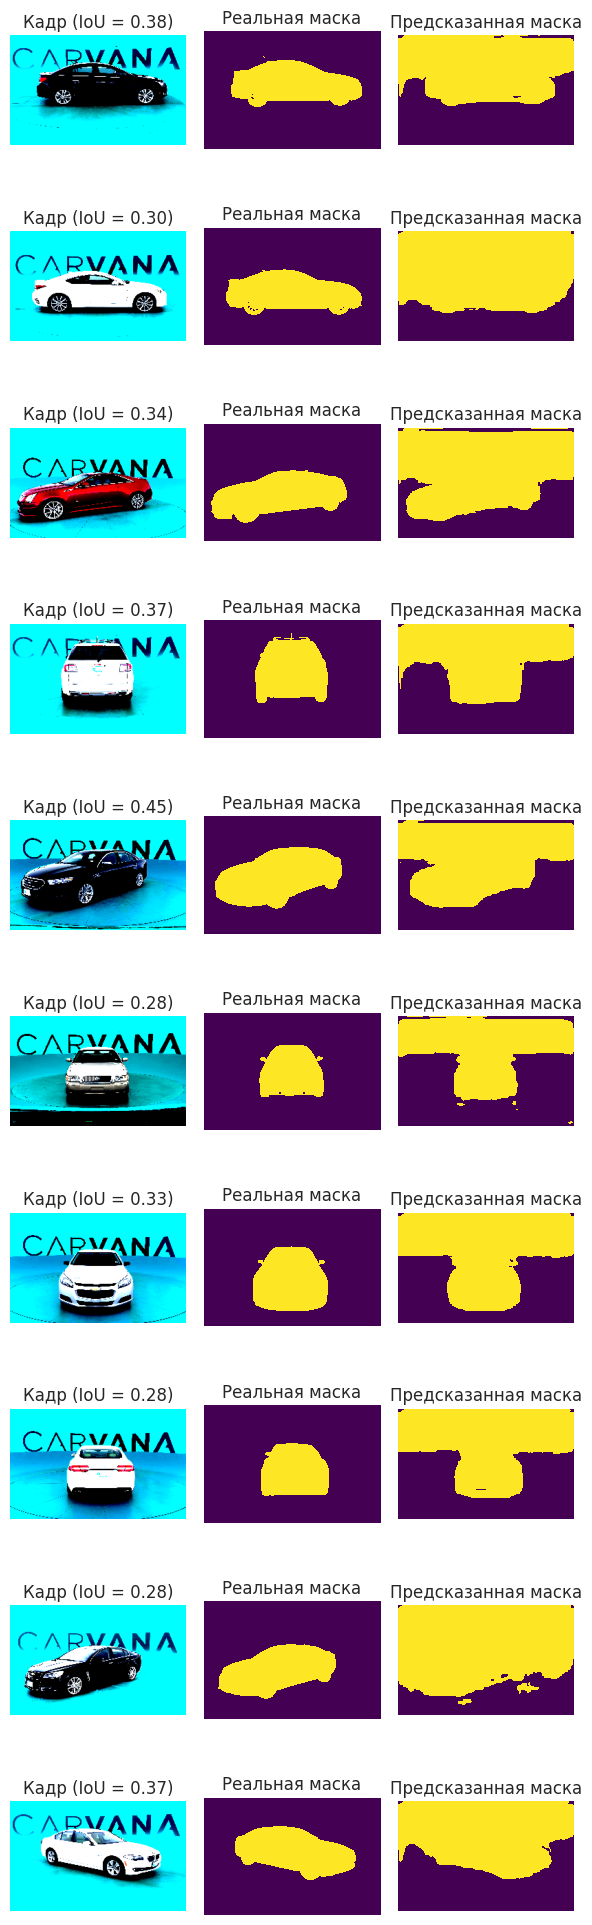

In [147]:
model.change_bg_color = True  # теперь при тесте модель выделит фон и покрасит его
model.predictions = []

trainer.test(model, dataloaders=test_loader)
modified_imgs, pred_masks, ious = [], [], []
for mod_img, mask, iou in model.predictions:
    modified_imgs.append(mod_img)
    pred_masks.append(mask)
    ious.append(iou)

images_filenames = test_images[:10]
cols, rows = 3, len(images_filenames)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 20))
plt.title('Работа сети')
for i, img_name in enumerate(images_filenames):
    _, mask = test_dataset._load(img_name)  
    ax[i, 0].imshow(np.moveaxis(modified_imgs[i], 0, 2))
    ax[i, 1].imshow(mask, interpolation="nearest", cmap='viridis')
    ax[i, 0].set_title(f"Кадр (IoU = {ious[i]:.2f})")
    ax[i, 1].set_title("Реальная маска")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].imshow(pred_masks[i], interpolation="nearest", cmap='viridis')
    ax[i, 2].set_title("Предсказанная маска")
    ax[i, 2].set_axis_off()
plt.tight_layout()

*После перекрашивания фона предсказанные маски выглядят очень плохо. Конкретно в этой задаче это не страшно, ведь небо\стены (фон у машин) в реальности не могут быть каких-то особенных цветов.  Но, например, в медицинских задачах это может стать существенно, так что стоит это учесть*

Ответьте на вопрос, модель научилась сегментировать машины или фон?

***Ответ:** похоже, модель научилась сегментировать не машины (как мы хотели), а фон. Как вариант, можно было усилить цветовые аугментации, чтобы попробоать компенсировать наблюдаемый эффект*

***Вывод:** в этой задаче удалось ближе познакомиться с сегментацией. Модель Unet++ переобучилась на фон и сильно упала по качеству при перекраске фона*

### Задача 2. Сравнение лоссов сегментации
Будем работать с датасетом [CityScapes](https://www.cityscapes-dataset.com/). Этот датасет состоит из кадров съемки автомобиля, движущегося по улицам  Германии. Проверим, насколько хорошо с ним справляются предобученные модели со структурой, отличной от U-Net. Скачайте [архив](https://disk.yandex.ru/d/J8gPv_bEiK-_QQ) с данными с диска. В папках `images` и `masks` лежат изображения и маски автомобилей соответственно.


In [148]:
max_epochs = 25  # в этой задаче побольше

In [149]:
data_path = Path('../input/cityscapes/cityscapes')
!ls $data_path

images	masks


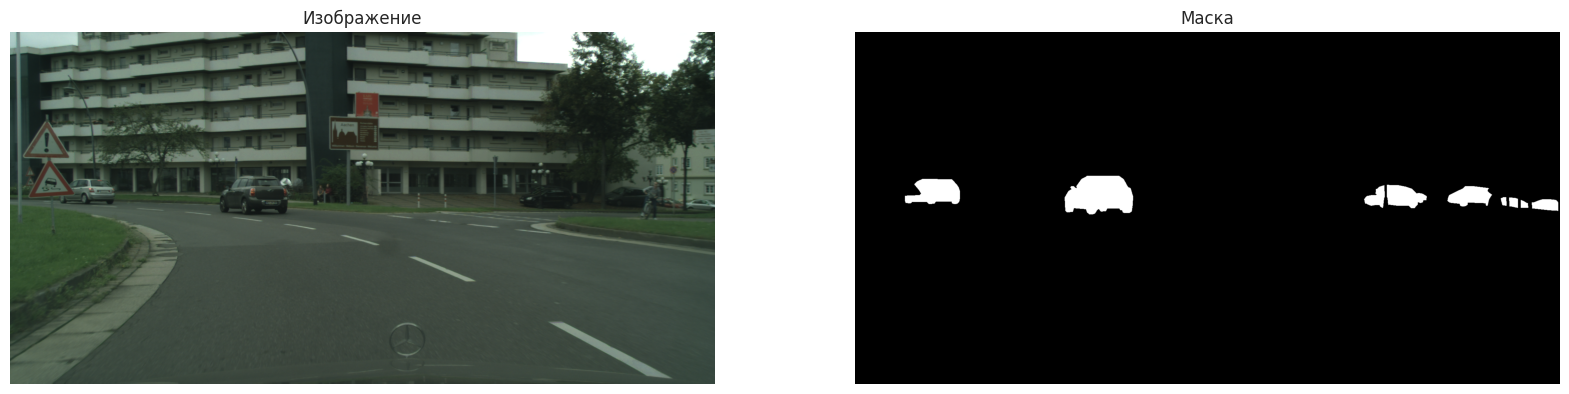

In [150]:
img_name = "aachen_000000_000019.png"
mask_name = img_name.replace('.png','_mask.png')

img_path = os.path.join(data_path, "images", img_name)
mask_path = os.path.join(data_path, "masks", mask_name)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(Image.open(mask_path))  # маски бинарные
plt.axis("off");

Определите датасет для CityScapes и даталоадеры.

In [151]:
# в этой задаче достаточно поделить на трейн и валидацию
train_images = os.listdir(data_path / 'images')
random.shuffle(train_images)
val_images = train_images[:len(train_images)//5]  # 20% -> в валидацию
train_images = list(set(train_images) - set(val_images))
assert len(set(train_images).intersection(set(val_images))) == 0 # убедились, что ликов нет
img_list = {'train':train_images, 'val':val_images}

class CityScapesDataset(Dataset):
    def __init__(self, mode='train', transform=None):
        self.img_dir, self.mask_dir, self.img_names = data_path / 'images', data_path / 'masks', img_list[mode]
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def _load(self, img_name):
        mask_name = img_name.replace('.png','_mask.png')
        image = np.array(Image.open(self.img_dir / img_name)).astype(float)
        mask = np.array(Image.open(self.mask_dir / mask_name)).astype(float)
        return image, mask

    def __getitem__(self, idx):
        image, mask = self._load(self.img_names[idx])
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
        return image, mask

size = (160, 256)
train_transform = A.Compose([
    A.Resize(*size),  
    # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),  # аугментации явно не упоминались, начнем без них
    # A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
    # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    # A.GaussNoise(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
val_test_transform = A.Compose([
    A.Resize(*size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

batch_size, num_workers = 32, 2
train_dataset = CityScapesDataset('train', transform=train_transform)
val_dataset = CityScapesDataset('val', transform=val_test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Определите класс модуля lightning для обучения модели сегментации машин. В качестве модели используйте предобученную `fcn_resnet50` или `deeplabv3_resnet50` из `torchvision.models.segmentation` на ваш выбор. Особенностью их использования является то, что модели дают на выходе маски для 21 класса (как в COCO) в поле `out` (см. примеры в семинаре). В остальном модели не отличаются от тех, что мы использовали ранее.

Наша цель - сравнить работу 3 лоссов - Binary Cross Entropy, Dice Loss, Tversky Loss. Реализацию двух последних можно взять из библиотеки [monai](https://docs.monai.io/en/stable/losses.html).

В качестве метрики используйте IoU.

In [152]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, loss='bce'):
        '''Инициализация'''
        super().__init__()
        if loss=='bce':
            self.lr = 3e-4
            self.criterion = nn.BCEWithLogitsLoss()
        elif loss=='dice':
            self.lr = 5e-5
            self.criterion = monai.losses.DiceLoss()
        elif loss=='tversky':    
            self.lr = 5e-5
            self.criterion = monai.losses.TverskyLoss(alpha=1.0, beta=0.5)
        self.save_hyperparameters()
        self.model = torchvision.models.segmentation.fcn_resnet50(weights='DEFAULT')
        self.predictions = []
        self.logs = {'Лосс':{'train':[],'val':[]}, 'IoU':{'train':[],'val':[]}}
        self.training_step_outputs_loss, self.training_step_outputs_iou = [],[]
        self.validation_step_outputs_loss, self.validation_step_outputs_iou = [],[]
        self.change_bg_color = False

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)['out']

    def __step(self, batch):
        '''Лосс с 1 шага обучения по батчу'''
        images, target = batch
        output = self.forward(images)[:,0,...]
        target = target.float()
        loss = self.criterion(output, target)
        pred = (torch.sigmoid(output) >= 0.5)
        inter, union = torch.logical_and(target, pred).sum(), torch.logical_or(target, pred).sum() 
        iou = inter / union if union != 0 else torch.tensor(0.0)
        return loss, iou

    def training_step(self, batch, batch_idx):
        '''Шаг трейна'''
        loss, iou = self.__step(batch)
        self.training_step_outputs_loss.append(loss)
        self.training_step_outputs_iou.append(iou)
        return loss

    def on_train_epoch_end(self):
        '''Логи в конце трейна'''
        self.logs['Лосс']['train'].append(torch.stack(self.training_step_outputs_loss).mean().item())
        self.logs['IoU']['train'].append(torch.stack(self.training_step_outputs_iou).mean().item())
        self.training_step_outputs_loss.clear()
        self.training_step_outputs_iou.clear()

    def validation_step(self, batch, batch_idx):
        '''Шаг валидации'''
        loss, iou = self.__step(batch)
        self.validation_step_outputs_loss.append(loss)
        self.validation_step_outputs_iou.append(iou)
        return loss

    def on_validation_epoch_end(self):
        '''Логи в конце валидации'''
        self.logs['Лосс']['val'].append(torch.stack(self.validation_step_outputs_loss).mean().item())
        self.logs['IoU']['val'].append(torch.stack(self.validation_step_outputs_iou).mean().item())
        self.validation_step_outputs_loss.clear()
        self.validation_step_outputs_iou.clear()

    def test_step(self, batch, batch_idx):
        '''Тестоый прогон'''
        images, targets = batch
        targets = targets.float()
        outputs = self.forward(images)[:,0,...]
        pred_masks = (torch.sigmoid(outputs) >= 0.5)
        for img, pred, target in zip(images, pred_masks, targets):
            inter, union = torch.logical_and(target, pred).sum(), torch.logical_or(target, pred).sum() 
            iou = inter / union if union != 0 else torch.tensor(0.0)
            self.predictions.append((pred.cpu().numpy(), iou))

    def visualize(self):
        '''Визуализация кривых лосса и iou'''
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        for ax, param in zip(axs, ['Лосс','IoU']):
            ax.plot(self.logs[param]['train'], label='Трейн')
            ax.plot(self.logs[param]['val'][1:], label='Валидация')
            ax.set_title(f'{param} в динамике')
            ax.set_xlabel('Эпоха')
            ax.set_ylabel(param)
            ax.legend()
        plt.tight_layout()
        plt.show()

#### Визуализация до обучения

До обучения визуализируйте несколько предсказаний модели на тестовой части CityScapes. Покажите исходную картинку, предсказание модели и истинную маску. Не забудьте брать предсказания только по каналу машин.

Testing: |          | 0/? [00:00<?, ?it/s]

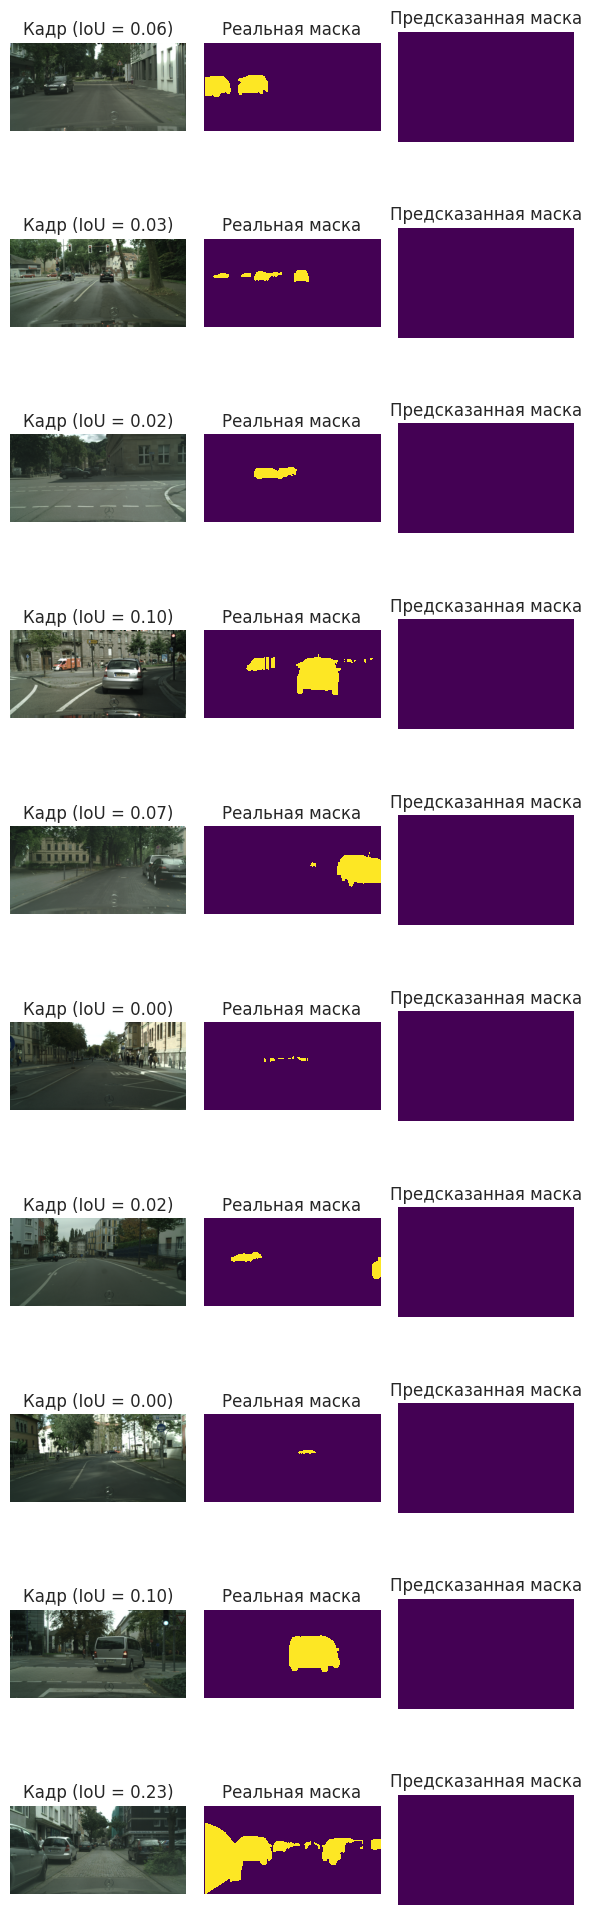

In [153]:
model = SegmentationModel()

trainer.test(model, dataloaders=val_loader)
pred_masks, ious = [mask for mask, _ in model.predictions], [iou for _, iou in model.predictions]

images_filenames = val_images[:10]
cols, rows = 3, len(images_filenames)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 20))
plt.title('Работа сети')
for i, img_name in enumerate(images_filenames):
    image, mask = val_dataset._load(img_name)  
    ax[i, 0].imshow(image.astype(int))
    ax[i, 1].imshow(mask, interpolation="nearest", cmap='viridis')
    ax[i, 0].set_title(f"Кадр (IoU = {ious[i]:.2f})")
    ax[i, 1].set_title("Реальная маска")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].imshow(pred_masks[i], interpolation="nearest", cmap='viridis')
    ax[i, 2].set_title("Предсказанная маска")
    ax[i, 2].set_axis_off()
plt.tight_layout()

#### Binary Cross Entropy

Обучите предобученную модель, используя BCE Loss. Сравните несколько предсказаний с истинными масками на тестовой выборке. Также после обучения (до завершения wandb run) выведите IoU на тесте с помощью `trainer.validate`.

In [ ]:
model = SegmentationModel(loss='bce')
trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[pl.callbacks.ModelCheckpoint()])
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

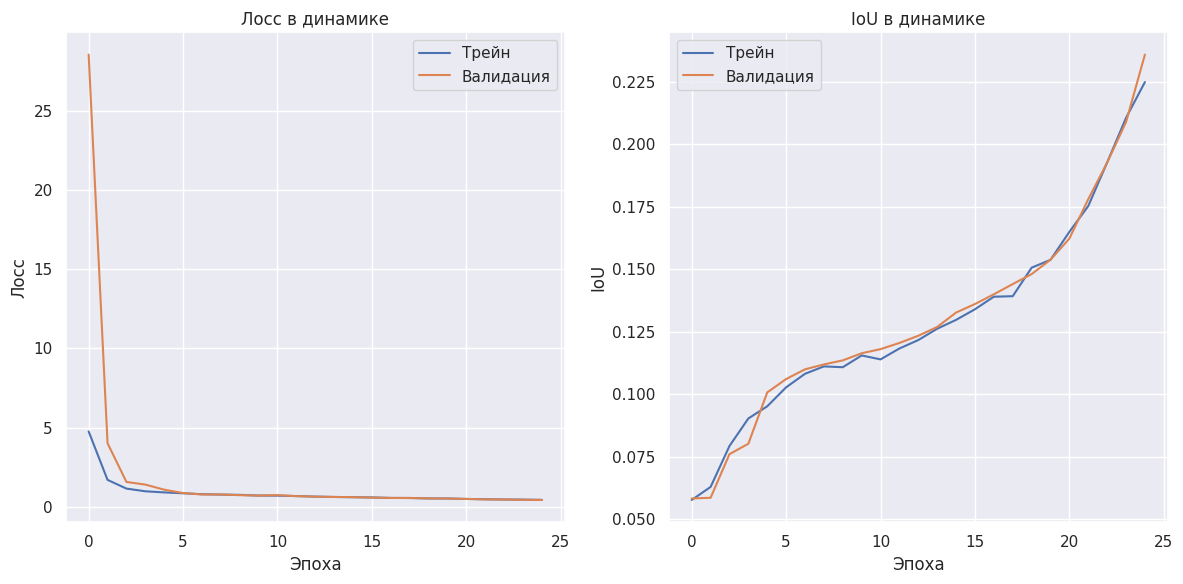

In [155]:
model.visualize()

Testing: |          | 0/? [00:00<?, ?it/s]

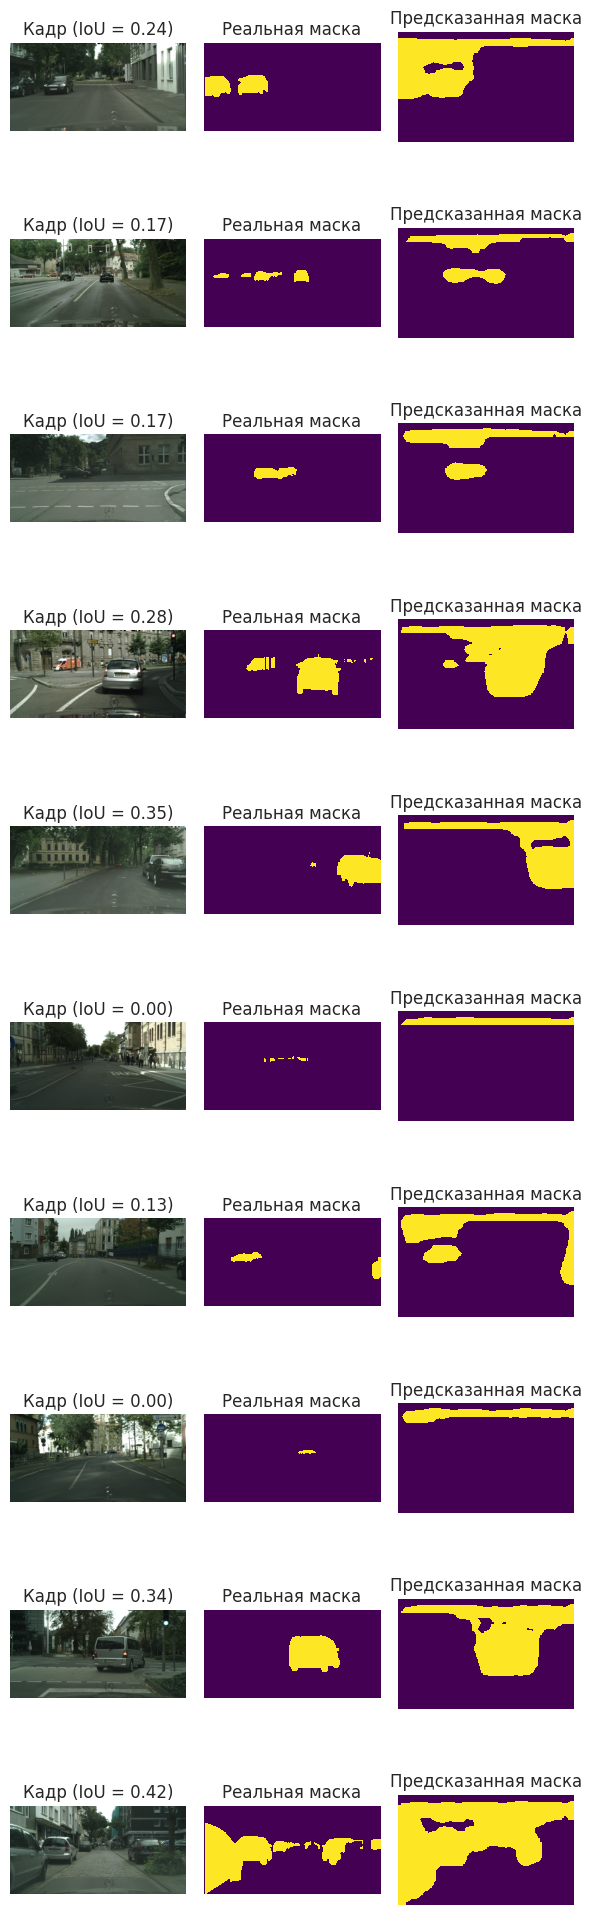

In [156]:
trainer.test(model, dataloaders=val_loader)
pred_masks, ious = [mask for mask, _ in model.predictions], [iou for _, iou in model.predictions]

images_filenames = val_images[:10]
cols, rows = 3, len(images_filenames)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 20))
plt.title('Работа сети')
for i, img_name in enumerate(images_filenames):
    image, mask = val_dataset._load(img_name)  
    ax[i, 0].imshow(image.astype(int))
    ax[i, 1].imshow(mask, interpolation="nearest", cmap='viridis')
    ax[i, 0].set_title(f"Кадр (IoU = {ious[i]:.2f})")
    ax[i, 1].set_title("Реальная маска")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].imshow(pred_masks[i], interpolation="nearest", cmap='viridis')
    ax[i, 2].set_title("Предсказанная маска")
    ax[i, 2].set_axis_off()
plt.tight_layout()

#### Dice Loss

Сделайте то же самое для Dice Loss.

In [157]:
model = SegmentationModel(loss='dice')
trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[pl.callbacks.ModelCheckpoint()])
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

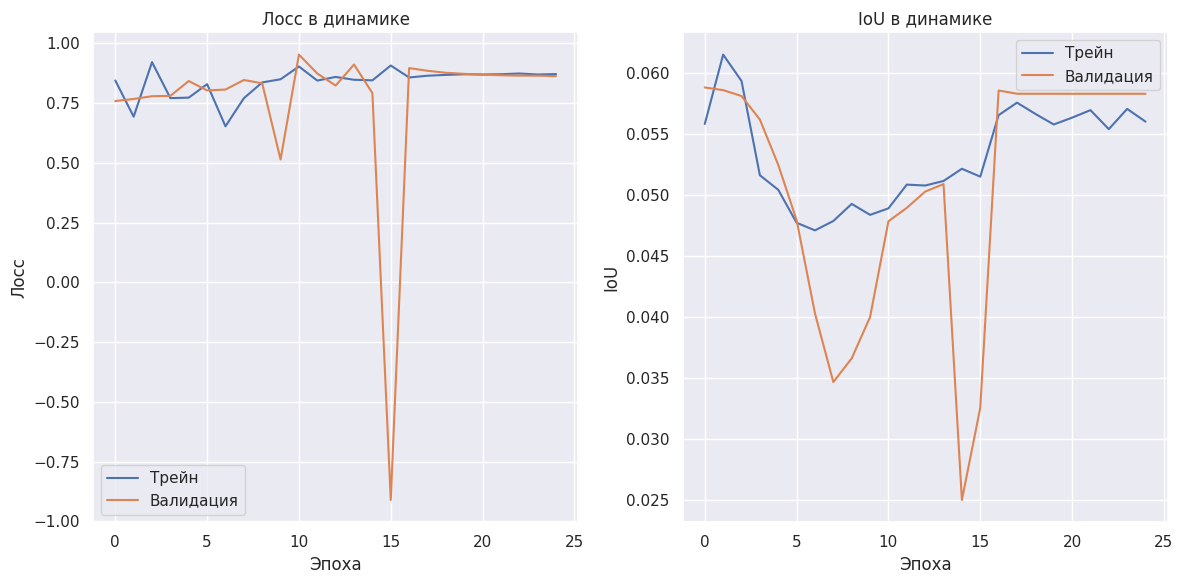

In [158]:
model.visualize()

Testing: |          | 0/? [00:00<?, ?it/s]

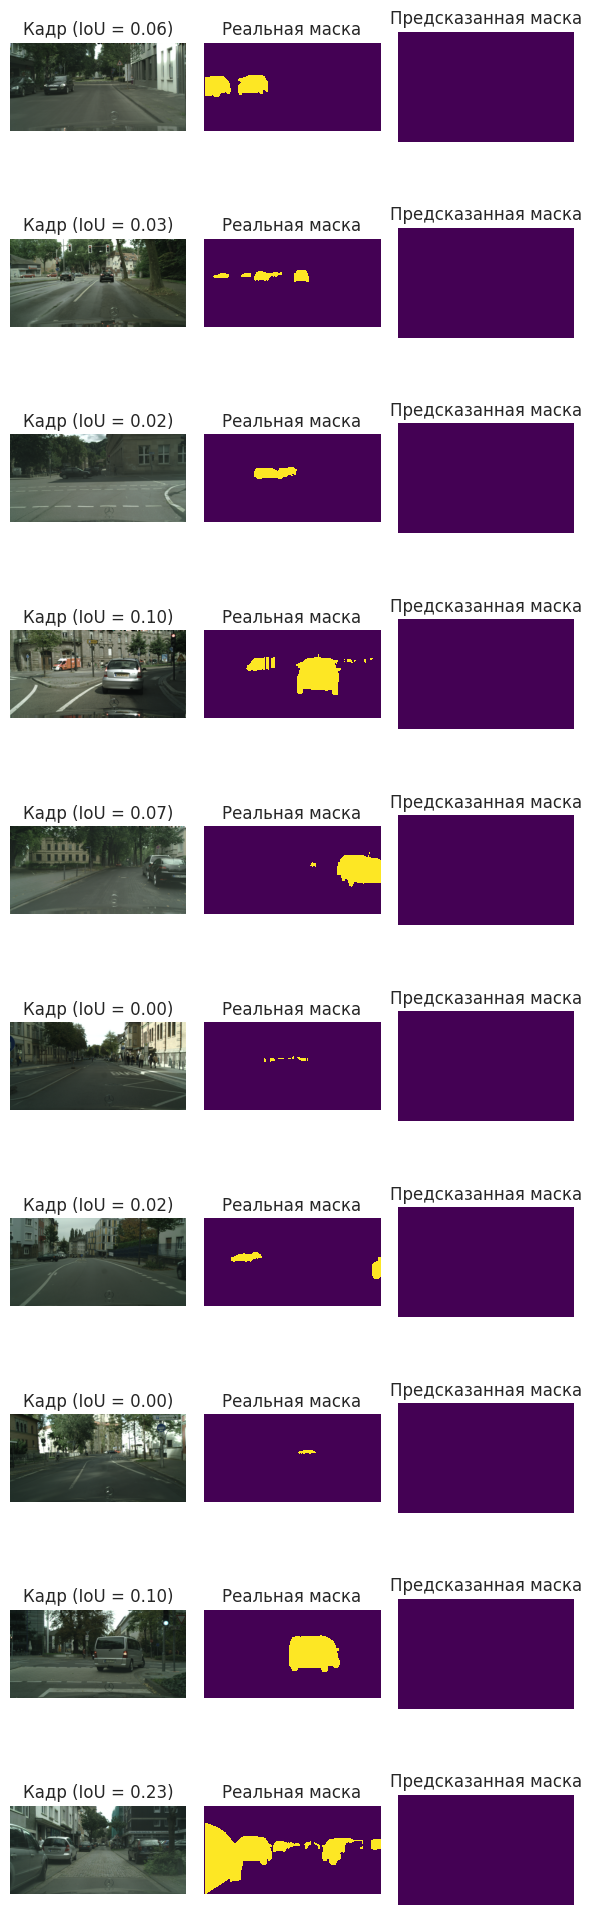

In [159]:
trainer.test(model, dataloaders=val_loader)
pred_masks, ious = [mask for mask, _ in model.predictions], [iou for _, iou in model.predictions]

images_filenames = val_images[:10]
cols, rows = 3, len(images_filenames)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 20))
plt.title('Работа сети')
for i, img_name in enumerate(images_filenames):
    image, mask = val_dataset._load(img_name)  
    ax[i, 0].imshow(image.astype(int))
    ax[i, 1].imshow(mask, interpolation="nearest", cmap='viridis')
    ax[i, 0].set_title(f"Кадр (IoU = {ious[i]:.2f})")
    ax[i, 1].set_title("Реальная маска")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].imshow(pred_masks[i], interpolation="nearest", cmap='viridis')
    ax[i, 2].set_title("Предсказанная маска")
    ax[i, 2].set_axis_off()
plt.tight_layout()

Судя по визуализации, чего больше у модели - False Negative или False Positive предсказаний?

*Больше False Positives: маска содержит много лишних пикселей*

#### Tversky Loss

Tversky Index является обобщением Dice Index для произвольных весов при FP и FN:

$$T_{\alpha, \beta} (y, \hat{y}) = \frac{\text{TP}}{\text{TP} + \alpha \ \text{FP} + \beta \ \text{FN}}$$

При этом $T_{\frac{1}{2}, \frac{1}{2}}$ соответсвует Dice Index; а $T_{1, 1} - $ Jaccard index (IoU).

Исходя из выводов про FN и FP подберите параметры $\alpha, \beta$ у Tversky Loss для модели. Обучите ее с таким лоссом. Улучшилась ли метрика? Как изменились предсказания визуально?

*Попробуем $\alpha=1$, $\beta=1/2$*

In [160]:
model = SegmentationModel(loss='tversky')
trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[pl.callbacks.ModelCheckpoint()])
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

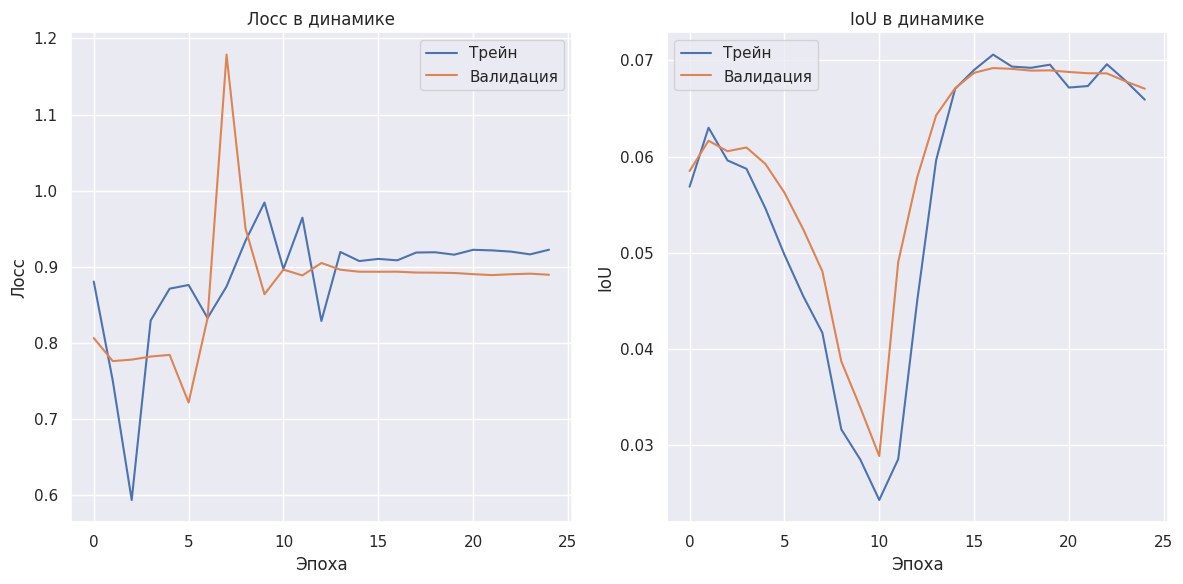

In [161]:
model.visualize()

Testing: |          | 0/? [00:00<?, ?it/s]

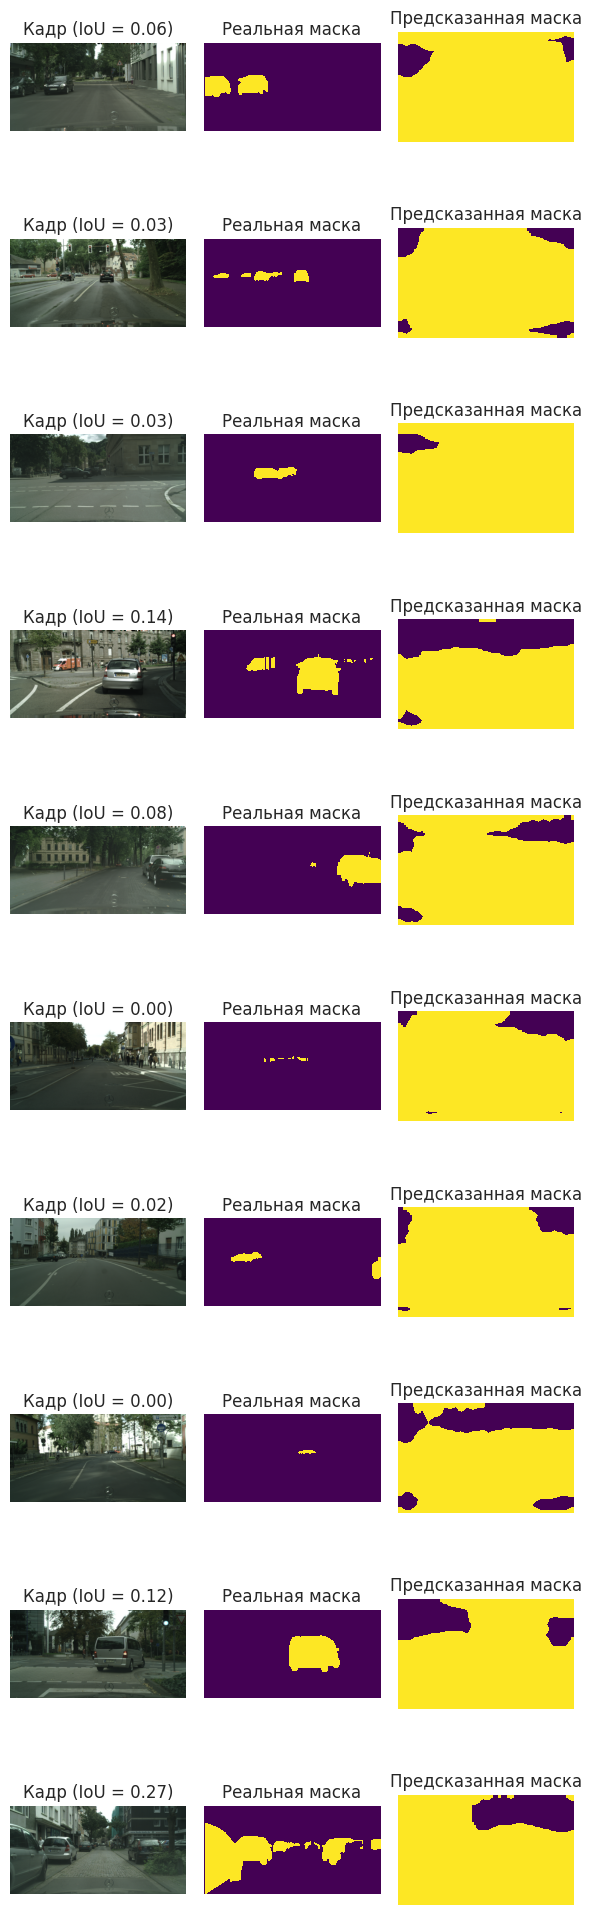

In [162]:
trainer.test(model, dataloaders=val_loader)
pred_masks, ious = [mask for mask, _ in model.predictions], [iou for _, iou in model.predictions]

images_filenames = val_images[:10]
cols, rows = 3, len(images_filenames)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 20))
plt.title('Работа сети')
for i, img_name in enumerate(images_filenames):
    image, mask = val_dataset._load(img_name)  
    ax[i, 0].imshow(image.astype(int))
    ax[i, 1].imshow(mask, interpolation="nearest", cmap='viridis')
    ax[i, 0].set_title(f"Кадр (IoU = {ious[i]:.2f})")
    ax[i, 1].set_title("Реальная маска")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].imshow(pred_masks[i], interpolation="nearest", cmap='viridis')
    ax[i, 2].set_title("Предсказанная маска")
    ax[i, 2].set_axis_off()
plt.tight_layout()

*Принципиальных улучшений не вижу (ни по лоссу, ни визуально). Возможно, стоило обучать с аугментациями, получше подобрать гиперпараметры или просто подольше обучать*

*В целом, fcn справляется заметно хуже, чем unet++*

#### Визуализация логов обучения

Визуализируйте лосс и метрику на обучении и валидации на предыдущих запусках. Сравните и сделайте выводы, а также выводы по всей задаче.

*Мне показалось нагляднее рисовать графики лосса и метрики сразу в соответствующих подпунктах, так что графики см. выше*

**Выводы:**


*В этой задаче удалось ближе познакомиться с задачей сегментации, в частности, сравнить обучение моделей при разных лоссах. Лучше всего себя показала BCE (и сетка unet++)*